# RNN Implementation

Author: Sara Hoxha

In [1]:
import pandas as pd
import pickle
import torch
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from preprocessing import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np
from keras import regularizers
import keras_tuner as kt
from utils import *
from metrics_plot_utils import *
import keras
from tensorflow.keras.utils import to_categorical,pad_sequences

[nltk_data] Downloading package punkt_tab to /Users/sara/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Yangswei_85 Dataset

To use the Yangswei_85 dataset, run the cell below.

In [13]:
# Load training set
df_train = pd.read_csv('data/train_yangswei_85.csv')  
# Load test set
test_df = pd.read_csv('data/test_yangswei_85.csv')
dataset_name = 'Yangswei_85'

# T5 Dataset
To use the T5 dataset, run the cell below.

In [8]:
# Load training set
df_train = pd.read_csv('data/train_t5.csv')  
# Load test set
test_df = pd.read_csv('data/test_t5.csv')
dataset_name = 'T5'

# Training and Validation

## Training Data Preprocessing

Firstly, we apply preprocessing (fixing contractions, setting all text to lowercase, removing non-alphanumeric characters) to the training text.

Secondly, we tokenize and pad the training text using TensorFlow Keras TextVectorization.  To reuse the tokenizer during the testing preprocessing, we save the tokenizer in a pickle file.

Lastly, we encode the labels of the training dataset and save them to a npy file called 'label_classes.npy'.

In [ ]:
#Preprocess training data
df_train['text'].apply(preprocess).to_frame()

# Tokenize and pad training data
padded_sequences, tokenizer, vocab_size = tokenize_and_pad(df_train[['text']])

#Save tokenizer in a pickle file to reuse
with open(f'data/tokenizers/tokenizer_rnn_{dataset_name}.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Set training data
padded_train_data = padded_sequences

#Encode labels and save classes in npy file
label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])
np.save('data/label_classes.npy', label_encoder.classes_)
train_labels = torch.tensor(label_encoder.transform(df_train['label']),dtype=torch.long)
num_classes = len(label_encoder.classes_)
train_labels_one_hot_encoded = to_categorical(train_labels)

## Define RNN model & Tune Hyperparameters
In the cell below, we define and tune a Recurrent Neural Network (RNN) model using Keras Tuner's Random Search.

In [ ]:
#Define architecture of RNN
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Choice('output_dim', [64, 128])))

    # Set an adjustable number of RNN layers (max 2)
    num_layers = hp.Int('num_layers', min_value=1, max_value=2, step=1)
    for i in range(num_layers):
        units = hp.Int(f'rnn_units_{i}', min_value=32, max_value=128, step=32)
        model.add(SimpleRNN(units, return_sequences=(i < num_layers - 1), kernel_regularizer=regularizers.l2(1e-3)))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#Create a keras tuner to find the best hyperparameters
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,  
    executions_per_trial=2,
    directory='tuning_best_models', 
    project_name=f'rnn_{dataset_name}'  
)

#Search for the best hyperparameters
tuner.search(padded_train_data, train_labels_one_hot_encoded, epochs=7, validation_split=0.2, batch_size=64)

#Get the best hyperparameters and print them
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

## Train and Validate best model

In the cell below, we conduct the training and validation of the tuned RNN model. We set two callbaks (Checkpoint & Early Stopping) to save the best model based on validation loss and stop training if the validation loss does not improve for a specified number of epochs (15) respectively. The traing and validation losses are extracted from the training history and plotted.

In [ ]:
print("Start Training and Validation:\n")
epochs = 50
patience = 15
batch_size = 64


#Build RNN model using best hyperparameters
rnn_model = build_model(best_hps)
#Set the path for best model
best_model_file_name = f'models/best_rnn_model_{dataset_name}.keras'
#Define callbacks
model_checkpoint = ModelCheckpoint(best_model_file_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

#Train model
history = rnn_model.fit(
    padded_train_data, 
    train_labels_one_hot_encoded, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    callbacks=[early_stopping, model_checkpoint], 
    verbose=1
)

# Extract training and validation losses
train_losses = history.history['loss']
val_losses = history.history['val_loss']
actual_epochs =  len(train_losses)
# Plot training and validation losses
plot_losses("RNN", dataset_name, train_losses, val_losses, actual_epochs)


# Test

## Test Data Preprocessing

Here we conduct the same preprocessing to the test data as done for the training data, using also the same tokenizer which we load from the saved pickle file.

In [11]:
# Preprocess test data
test_df['text'].apply(preprocess).to_frame()  

#Load tokenizer used in training
with open(f'data/tokenizers/tokenizer_rnn_{dataset_name}.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Tokenize and pad test data using the same tokenizer from training
padded_test_sequences = tokenizer(test_df['text'])
padded_test_sequences = pad_sequences(padded_test_sequences, maxlen=padded_train_data.shape[1])

# Set test data
test_data = padded_sequences

#Encode test labels by loading encoder used for training labels
true_labels = test_df['label']
label_classes = np.load('data/label_classes.npy', allow_pickle=True)
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes
test_labels = torch.tensor(label_encoder.transform(true_labels))
test_labels_one_hot_encoded = to_categorical(test_labels, num_classes=num_classes)

KeyboardInterrupt: 

## Test best model on test data

In [5]:

# Load the saved model
best_model_file_name = f'models/best_rnn_model_{dataset_name}.h5'
model = tf.keras.models.load_model(best_model_file_name)

#Test model
test_loss, test_accuracy = model.evaluate(padded_test_sequences, test_labels_one_hot_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

#Extract predictions and probabilities
predictions_probabilities = model.predict(padded_test_sequences)
predicted_classes = label_encoder.inverse_transform(np.argmax(predictions_probabilities, axis=1))
#Decode the true labels
true_classes = label_encoder.inverse_transform(np.argmax(test_labels_one_hot_encoded, axis=1))

697/697 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6429 - loss: 1.0596
Test Loss: 1.0600, Test Accuracy: 0.6411
697/697 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


## Compute metrics on model performance

/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dictionary saved to results/metrics_rnn_Yangswei_85.txt
Test Accuracy: 0.6411


Macro Metrics
Macro Precision: 0.3956
Macro Recall: 0.2336
Macro F1 Score: 0.2443


Weighted Metrics
Weighted Precision: 0.6198
Weighted Recall: 0.6411
Weighted F1 Score: 0.5608
Confusion matrix saved to results/confusion_matrix_rnn_Yangswei_85.png


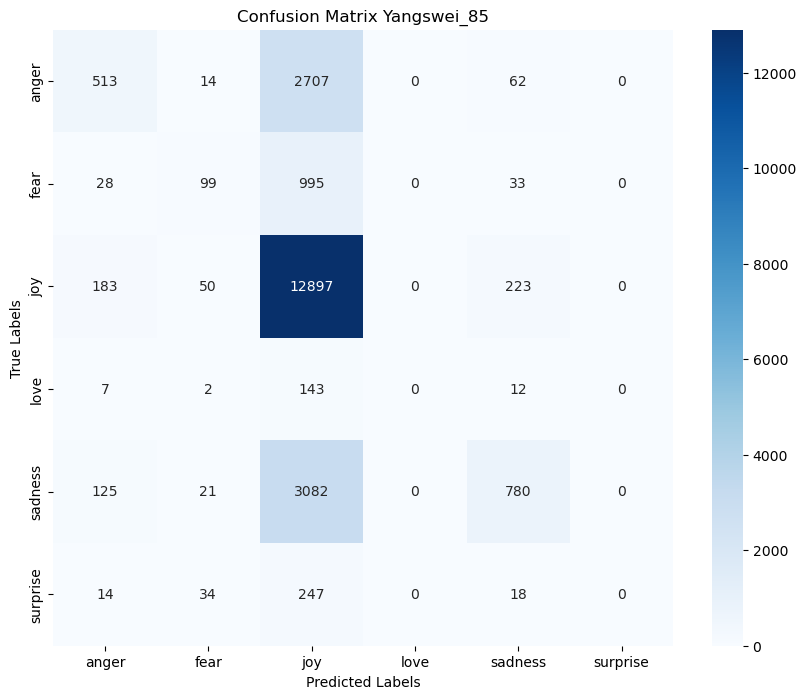

In [6]:
# Compute metrics
metrics = compute_metrics(predicted_classes, true_classes, f'results/RNN/metrics_rnn_{dataset_name}.txt')
print(f"Test Accuracy: {metrics['accuracy']:.4f}")
print('\n')
print('Macro Metrics')
print(f"Macro Precision: {metrics['precision']:.4f}")
print(f"Macro Recall: {metrics['recall']:.4f}")
print(f"Macro F1 Score: {metrics['f1']:.4f}")
print('\n')
print('Weighted Metrics')
print(f"Weighted Precision: {metrics['precision_weighted']:.4f}")
print(f"Weighted Recall: {metrics['recall_weighted']:.4f}")
print(f"Weighted F1 Score: {metrics['f1_weighted']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, label_classes, dataset_name, f'results/RNN/confusion_matrix_rnn_{dataset_name}.png')

In [7]:
# Print classification report
print(f'Classification Report {dataset_name}:\n')
print(classification_report(true_classes, predicted_classes, target_names=label_classes))


Classification Report Yangswei_85:



/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.59      0.16      0.25      3296
        fear       0.45      0.09      0.14      1155
         joy       0.64      0.97      0.77     13353
        love       0.00      0.00      0.00       164
     sadness       0.69      0.19      0.30      4008
    surprise       0.00      0.00      0.00       313

    accuracy                           0.64     22289
   macro avg       0.40      0.23      0.24     22289
weighted avg       0.62      0.64      0.56     22289



/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
